<a href="https://colab.research.google.com/github/fotisz/ActiveBuildings/blob/master/open_buildings_spatial_analysis_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 Google LLC. Licensed under the Apache License, Version 2.0 (the "License");

# Open Buildings - spatial analysis examples

This notebook demonstrates some analysis methods with [Open Buildings](https://sites.research.google/open-buildings/) data:

* Generating heatmaps of building density and size.


In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License

### Download buildings data for a region in Africa [takes up to 15 minutes for large countries]

In [ ]:
#@markdown Select a region from either the [Natural Earth low res](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/) (fastest), [Natural Earth high res](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/) or [World Bank high res](https://datacatalog.worldbank.org/dataset/world-bank-official-boundaries) shapefiles:
region_border_source = 'Natural Earth (High Res 10m)'  #@param ["Natural Earth (Low Res 110m)", "Natural Earth (High Res 10m)", "World Bank (High Res 10m)"]
region = 'SEN (Senegal)'  #@param ["", "BGD (Bangladesh)", "CRI (Costa)", "MOZ (Mozambique)", "DMA (Dominica)", "BGD (Bangladesh)", "NLD (Netherlands)", "KEN (Kenya)", "IDN (Indonesia)", "COL (Colombia)","SEN (Senegal)", "ZAF (South Africa)"]

#@markdown Alternatively, specify an area of interest in [WKT format](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) (assumes crs='EPSG:4326'); this [tool](https://arthur-e.github.io/Wicket/sandbox-gmaps3.html) might be useful.
your_own_wkt_polygon = ''  #@param {type:"string"}
#@markdown Select type of data to download here:
data_type = 'points'  #@param ["polygons", "points"]
#@markdown In this analysis we only need centroids of buildings, therefore by default we use the data in the *point* format (files in *polygons* format are larger). Refer to [Open Buildings Data Format](https://sites.research.google/open-buildings/#dataformat) for more details.
!sudo apt-get install swig
!pip install s2geometry pygeos geopandas

import functools
import glob
import gzip
import multiprocessing
import os
import shutil
import tempfile
from typing import List, Optional, Tuple


import geopandas as gpd
from google.colab import files
from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s2geometry as s2
import shapely
import tensorflow as tf
import tqdm.notebook

BUILDING_DOWNLOAD_PATH = ('gs://open-buildings-data/v3/'
                          f'{data_type}_s2_level_6_gzip_no_header')

def get_filename_and_region_dataframe(
    region_border_source: str, region: str,
    your_own_wkt_polygon: str) -> Tuple[str, gpd.geodataframe.GeoDataFrame]:
  """Returns output filename and a geopandas dataframe with one region row."""

  if your_own_wkt_polygon:
    filename = f'open_buildings_v3_{data_type}_your_own_wkt_polygon.csv.gz'
    region_df = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries.from_wkt([your_own_wkt_polygon]),
        crs='EPSG:4326')
    if not isinstance(region_df.iloc[0].geometry,
                      shapely.geometry.polygon.Polygon) and not isinstance(
                          region_df.iloc[0].geometry,
                          shapely.geometry.multipolygon.MultiPolygon):
      raise ValueError("`your_own_wkt_polygon` must be a POLYGON or "
                      "MULTIPOLYGON.")
    print(f'Preparing your_own_wkt_polygon.')
    return filename, region_df

  if not region:
    raise ValueError('Please select a region or set your_own_wkt_polygon.')

  if region_border_source == 'Natural Earth (Low Res 110m)':
    url = ('https://www.naturalearthdata.com/http//www.naturalearthdata.com/'
           'download/110m/cultural/ne_110m_admin_0_countries.zip')
    !wget -N {url}
    display.clear_output()
    region_shapefile_path = os.path.basename(url)
    source_name = 'ne_110m'
  elif region_border_source == 'Natural Earth (High Res 10m)':
    url = ('https://www.naturalearthdata.com/http//www.naturalearthdata.com/'
           'download/10m/cultural/ne_10m_admin_0_countries.zip')
    !wget -N {url}
    display.clear_output()
    region_shapefile_path = os.path.basename(url)
    source_name = 'ne_10m'
  elif region_border_source == 'World Bank (High Res 10m)':
    url = ('https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/'
           '779551/wb_countries_admin0_10m.zip')
    !wget -N {url}
    !unzip -o {os.path.basename(url)}
    display.clear_output()
    region_shapefile_path = 'WB_countries_Admin0_10m'
    source_name = 'wb_10m'

  region_iso_a3 = region.split(' ')[0]
  filename = (f'open_buildings_v3_{data_type}_'
              f'{source_name}_{region_iso_a3}.csv.gz')
  region_df = gpd.read_file(region_shapefile_path).query(
      f'ISO_A3 == "{region_iso_a3}"').dissolve(by='ISO_A3')[['geometry']]
  print(f'Preparing {region} from {region_border_source}.')
  return filename, region_df


def get_bounding_box_s2_covering_tokens(
    region_geometry: shapely.geometry.base.BaseGeometry) -> List[str]:
  region_bounds = region_geometry.bounds
  s2_lat_lng_rect = s2.S2LatLngRect_FromPointPair(
      s2.S2LatLng_FromDegrees(region_bounds[1], region_bounds[0]),
      s2.S2LatLng_FromDegrees(region_bounds[3], region_bounds[2]))
  coverer = s2.S2RegionCoverer()
  # NOTE: Should be kept in-sync with s2 level in BUILDING_DOWNLOAD_PATH.
  coverer.set_fixed_level(6)
  coverer.set_max_cells(1000000)
  return [cell.ToToken() for cell in coverer.GetCovering(s2_lat_lng_rect)]


def s2_token_to_shapely_polygon(
    s2_token: str) -> shapely.geometry.polygon.Polygon:
  s2_cell = s2.S2Cell(s2.S2CellId_FromToken(s2_token, len(s2_token)))
  coords = []
  for i in range(4):
    s2_lat_lng = s2.S2LatLng(s2_cell.GetVertex(i))
    coords.append((s2_lat_lng.lng().degrees(), s2_lat_lng.lat().degrees()))
  return shapely.geometry.Polygon(coords)


def download_s2_token(
    s2_token: str, region_df: gpd.geodataframe.GeoDataFrame) -> Optional[str]:
  """Downloads the matching CSV file with polygons for the `s2_token`.

  NOTE: Only polygons inside the region are kept.
  NOTE: Passing output via a temporary file to reduce memory usage.

  Args:
    s2_token: S2 token for which to download the CSV file with building
      polygons. The S2 token should be at the same level as the files in
      BUILDING_DOWNLOAD_PATH.
    region_df: A geopandas dataframe with only one row that contains the region
      for which to keep polygons.

  Returns:
    Either filepath which contains a gzipped CSV without header for the
    `s2_token` subfiltered to only contain building polygons inside the region
    or None which means that there were no polygons inside the region for this
    `s2_token`.
  """
  s2_cell_geometry = s2_token_to_shapely_polygon(s2_token)
  region_geometry = region_df.iloc[0].geometry
  prepared_region_geometry = shapely.prepared.prep(region_geometry)
  # If the s2 cell doesn't intersect the country geometry at all then we can
  # know that all rows would be dropped so instead we can just return early.
  if not prepared_region_geometry.intersects(s2_cell_geometry):
    return None
  try:
    # Using tf.io.gfile.GFile gives better performance than passing the GCS path
    # directly to pd.read_csv.
    with tf.io.gfile.GFile(
        os.path.join(BUILDING_DOWNLOAD_PATH, f'{s2_token}_buildings.csv.gz'),
        'rb') as gf:
      # If the s2 cell is fully covered by country geometry then can skip
      # filtering as we need all rows.
      if prepared_region_geometry.covers(s2_cell_geometry):
        with tempfile.NamedTemporaryFile(mode='w+b', delete=False) as tmp_f:
          shutil.copyfileobj(gf, tmp_f)
          return tmp_f.name
      # Else take the slow path.
      # NOTE: We read in chunks to save memory.
      csv_chunks = pd.read_csv(
          gf, chunksize=2000000, dtype=object, compression='gzip', header=None)
      tmp_f = tempfile.NamedTemporaryFile(mode='w+b', delete=False)
      tmp_f.close()
      for csv_chunk in csv_chunks:
        points = gpd.GeoDataFrame(
            geometry=gpd.points_from_xy(csv_chunk[1], csv_chunk[0]),
            crs='EPSG:4326')
        # sjoin 'within' was faster than using shapely's 'within' directly.
        points = gpd.sjoin(points, region_df, predicate='within')
        csv_chunk = csv_chunk.iloc[points.index]
        csv_chunk.to_csv(
            tmp_f.name,
            mode='ab',
            index=False,
            header=False,
            compression={
                'method': 'gzip',
                'compresslevel': 1
            })
      return tmp_f.name
  except tf.errors.NotFoundError:
    return None

# Clear output after pip install.
display.clear_output()
filename, region_df = get_filename_and_region_dataframe(region_border_source,
                                                        region,
                                                        your_own_wkt_polygon)
# Remove any old outputs to not run out of disk.
for f in glob.glob('/tmp/open_buildings_*'):
  os.remove(f)
# Write header to the compressed CSV file.
with gzip.open(f'/tmp/{filename}', 'wt') as merged:
  if data_type == "polygons":
    merged.write(','.join([
        'latitude', 'longitude', 'area_in_meters', 'confidence', 'geometry',
        'full_plus_code'
    ]) + '\n')
  else:
    merged.write(','.join([
        'latitude', 'longitude', 'area_in_meters', 'confidence',
        'full_plus_code'
    ]) + '\n')
download_s2_token_fn = functools.partial(download_s2_token, region_df=region_df)
s2_tokens = get_bounding_box_s2_covering_tokens(region_df.iloc[0].geometry)
# Downloads CSV files for relevant S2 tokens and after filtering appends them
# to the compressed output CSV file. Relies on the fact that concatenating
# gzipped files produces a valid gzip file.
# NOTE: Uses a pool to speed up output preparation.
with open(f'/tmp/{filename}', 'ab') as merged:
  with multiprocessing.Pool(4) as e:
    for fname in tqdm.notebook.tqdm(
        e.imap_unordered(download_s2_token_fn, s2_tokens),
        total=len(s2_tokens)):
      if fname:
        with open(fname, 'rb') as tmp_f:
          shutil.copyfileobj(tmp_f, merged)
        os.unlink(fname)

Preparing BGD (Bangladesh) from Natural Earth (High Res 10m).


  0%|          | 0/25 [00:00<?, ?it/s]

# Visualise the data

First we convert the CSV file into a GeoDataFrame. The CSV files can be quite large when they include the polygon outline of every building, that is, when the data type downloaded is polygons. For this example we only need longitude and latitude, so we only process those columns to save memory.

In [ ]:
buildings = pd.read_csv(
    f"/tmp/{filename}", engine="c",
    usecols=['latitude', 'longitude', 'area_in_meters', 'confidence'])

print(f"Read {len(buildings):,} records.")

Read 37,504,904 records.


For some countries there can be tens of millions of buildings, so we also take a random sample for doing plots.

In [ ]:
sample_size = 200000  #@param

In [ ]:
buildings_sample = (buildings.sample(sample_size)
                    if len(buildings) > sample_size else buildings)

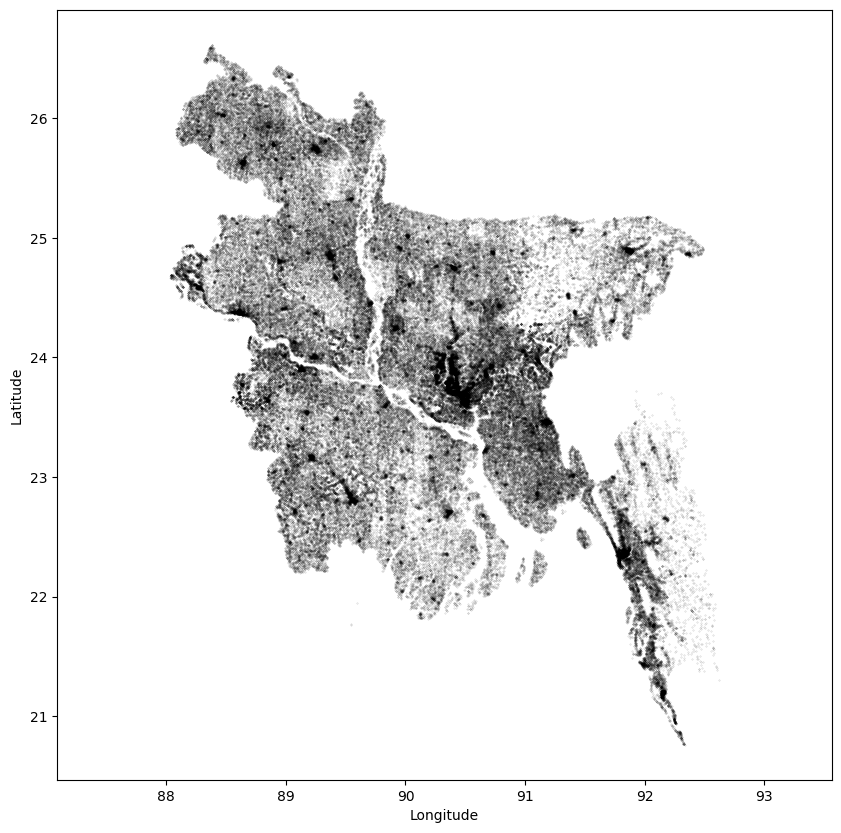

In [ ]:
plt.plot(buildings_sample.longitude, buildings_sample.latitude, 'k.',
         alpha=0.25, markersize=0.5)
plt.gcf().set_size_inches(10, 10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal');

# Prepare the data for mapping building statistics

Set up a grid, which we will use to calculate statistics about buildings.

We also want to select the examples most likely to be buildings, using a threshold on the confidence score.

In [ ]:
max_grid_dimension = 1000 #@param
confidence_threshold = 0.75 #@param

In [ ]:
buildings = buildings.query(f"confidence > {confidence_threshold}")

In [ ]:
# Create a grid covering the dataset bounds
min_lon = buildings.longitude.min()
max_lon = buildings.longitude.max()
min_lat = buildings.latitude.min()
max_lat = buildings.latitude.max()

grid_density_degrees = (max(max_lon - min_lon, max_lat - min_lat)
                        / max_grid_dimension)

bounds = [min_lon, min_lat, max_lon, max_lat]
xcoords = np.arange(min_lon, max_lon, grid_density_degrees)
ycoords = np.arange(max_lat, min_lat, -grid_density_degrees)
xv, yv = np.meshgrid(xcoords, ycoords)
xy = np.stack([xv.ravel(), yv.ravel()]).transpose()

print(f"Calculated grid of size {xv.shape[0]} x {xv.shape[1]}.")

Calculated grid of size 1000 x 785.


To calculate statistics, we need a function to convert between (longitude, latitude) coordinates in the world and (x, y) coordinates in the grid.

In [ ]:
geotransform = (min_lon, grid_density_degrees, 0,
                max_lat, 0, -grid_density_degrees)

def lonlat_to_xy(lon, lat, geotransform):
    x = int((lon - geotransform[0])/geotransform[1])
    y = int((lat - geotransform[3])/geotransform[5])
    return x,y

Now we can count how many buildings there are on each cell of the grid.

In [ ]:
counts = np.zeros(xv.shape)
area_totals = np.zeros(xv.shape)

for lat, lon, area in tqdm.notebook.tqdm(
    zip(buildings.latitude, buildings.longitude, buildings.area_in_meters)):
  x, y = lonlat_to_xy(lon, lat, geotransform)
  if x >= 0 and y >= 0 and x < len(xcoords) and y < len(ycoords):
    counts[y, x] += 1
    area_totals[y, x] += area

area_totals[counts == 0] = np.nan
counts[counts == 0] = np.nan
mean_area = area_totals / counts

0it [00:00, ?it/s]

# Plot the counts of buildings

Knowing the counts of buildings is useful for example in planning service delivery, estimating population or designing census enumeration areas.

<ipython-input-12-117767913b50>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{x:.0f}' for x in 10 ** cbar.ax.get_yticks()])


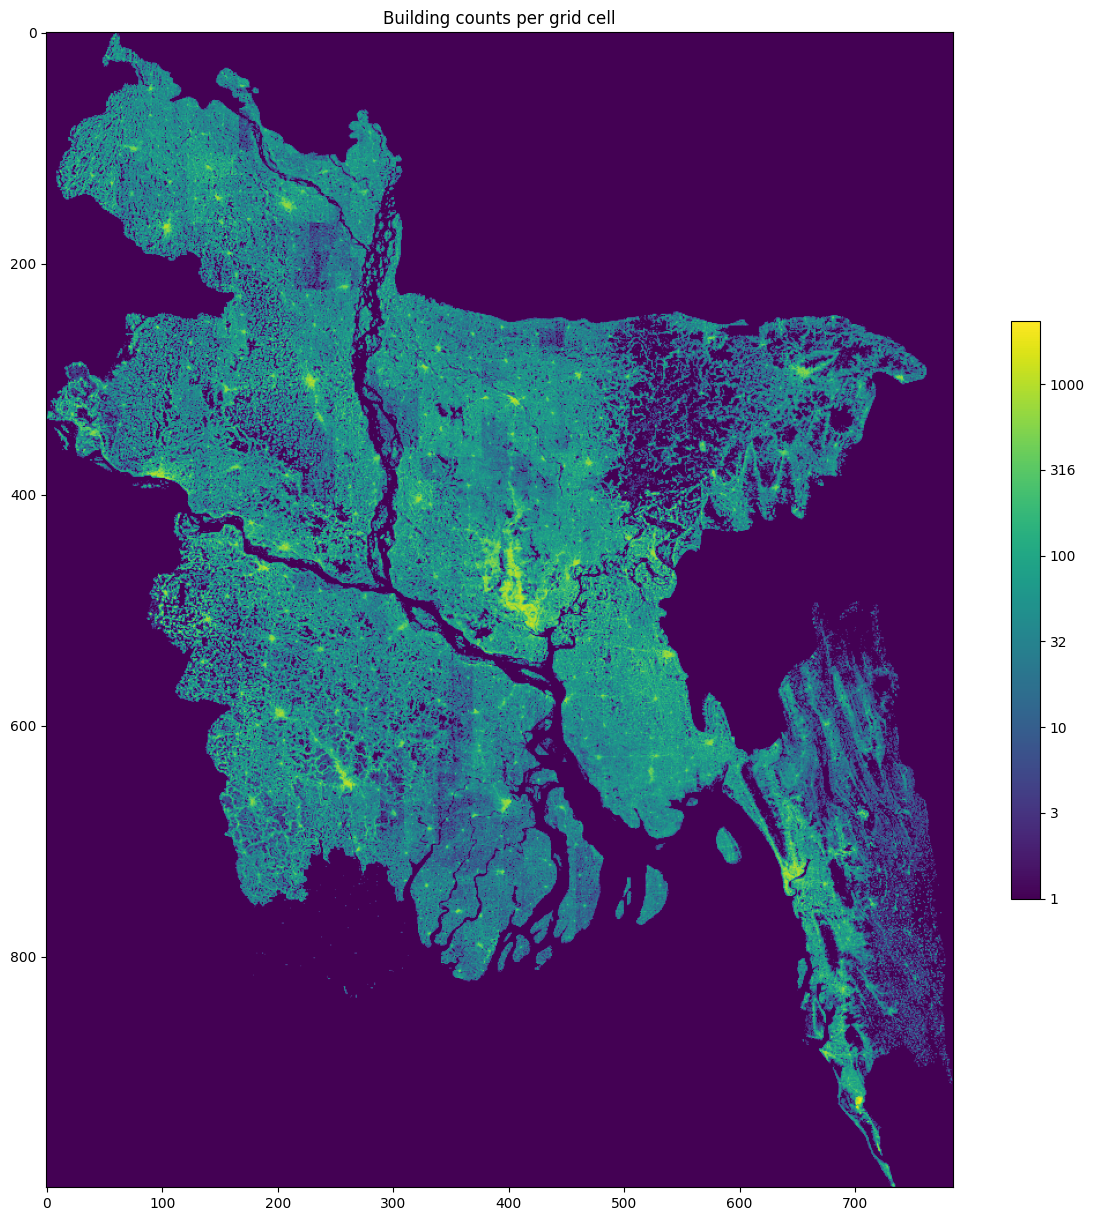

In [ ]:
plt.imshow(np.log10(np.nan_to_num(counts) + 1.), cmap="viridis")
plt.gcf().set_size_inches(15, 15)
cbar = plt.colorbar(shrink=0.5)
cbar.ax.set_yticklabels([f'{x:.0f}' for x in 10 ** cbar.ax.get_yticks()])
plt.title("Building counts per grid cell");

## [optional] Export a GeoTIFF file

This can be useful to carry our further analysis with software such as [QGIS](https://qgis.org/).

In [ ]:
def save_geotiff(filename, values, geotransform):
  driver = gdal.GetDriverByName("GTiff")
  dataset = driver.Create(filename, values.shape[1], values.shape[0], 1,
                          gdal.GDT_Float32)
  dataset.SetGeoTransform(geotransform)
  band = dataset.GetRasterBand(1)
  band.WriteArray(values)
  band.SetNoDataValue(-1)
  dataset.FlushCache()

filename = "building_counts.tiff"
save_geotiff(filename, counts, geotransform)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Generate a map of building sizes

Knowing average building sizes is useful too -- it is linked, for example, to how much economic activity there is in each area.

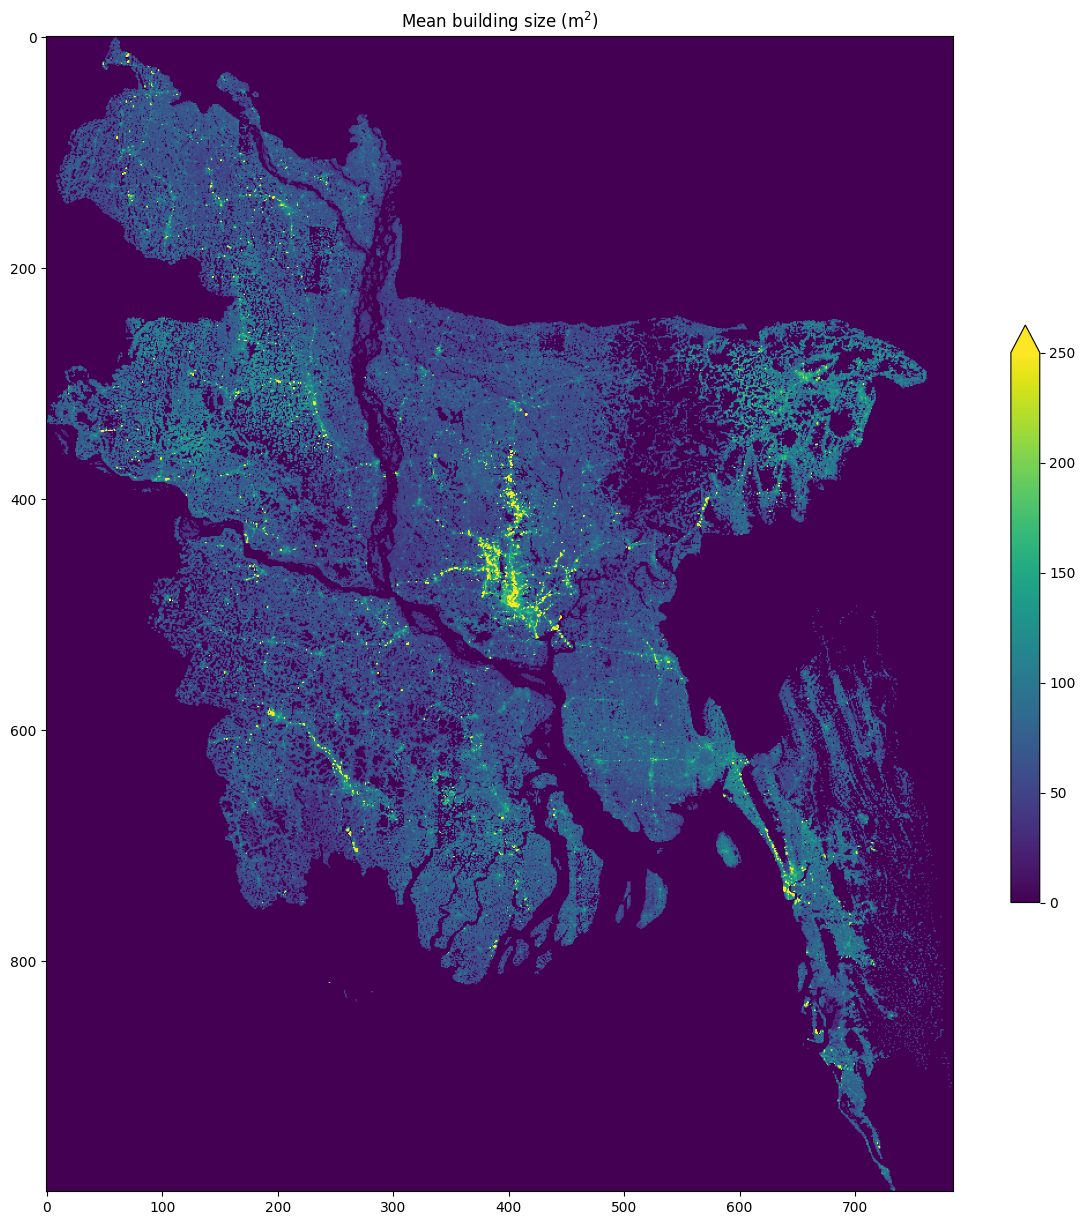

In [ ]:
# Only calculate the mean building size for grid locations with at
# least a few buildings, so that we get more reliable averages.
mean_area_filtered = mean_area.copy()
mean_area_filtered[counts < 10] = 0

# Set a maximum value for the colour scale, to make the plot brighter.
plt.imshow(np.nan_to_num(mean_area_filtered), vmax=250, cmap="viridis")
plt.title("Mean building size (m$^2$)")
plt.colorbar(shrink=0.5, extend="max")
plt.gcf().set_size_inches(15, 15)